# Data analysis of the Titanic data set from kaggle
website: https://www.kaggle.com/competitions/titanic

written by Frank M.

# To DO

#Next steps
cluster model

neural network

# Overview
## 1 Prepare notebook and read files
## 2 Deep look at the data
## 3 Modeling and prediction

---

## 1. Prepare notebook and read files
## 1.1 Import bib, functions and files

In [1]:
#import bibs
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os #for relative paths


#import functions from bibs
from sklearn.model_selection    import train_test_split
from sklearn.tree               import DecisionTreeClassifier
from sklearn.tree               import DecisionTreeRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.ensemble           import RandomForestRegressor
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import mean_absolute_error
from sklearn.preprocessing      import LabelEncoder
from sklearn.impute             import SimpleImputer
from scipy                      import stats
from sklearn.metrics            import confusion_matrix

#import files
true_data_filepath = 'data/gender_submission.csv'
train_filepath = 'data/train.csv'
test_filepath = 'data/test.csv'

#create data file with the real data
true_data = pd.read_csv(true_data_filepath)

## 1.2 Create class for data preparation

In [2]:
#class definiion
class PrepData:
    #constructor
    def __init__(self, filepath):
        #initialization
        self.filepath = filepath

        #read data
        self.data = pd.read_csv(filepath)

    #run all defined functions
    def RunAll(self):
        self.SurvivalRow()
        #self.SplitName()
        #self.LabelEncoding()
        return self.data

    #check for row named 'Survived'. It is missing in the test_data.
    def SurvivalRow(self):
        #condition if row already exists
        if 'Survived' not in self.data.columns:
            self.data['Survived'] = None
            return
        else:
            return

    #split name into: Lastname, Salutation and Name
    def SplitName(self):
        #split last name from Name Column (n=1: means only at the first ',', expand=True makes separate rows)
        self.data[['LastName', 'Name_temp']] = self.data['Name'].str.split(',', n=1, expand=True)

        #split salutation from Name
        self.data[['Salutation', 'Surname']] = self.data['Name_temp'].str.split('.', n=1, expand=True)

        #delete Name_temp
        self.data = self.data.drop(columns='Name_temp')

        #clean data from ' '
        self.data['LastName'] = self.data['LastName'].str.strip()

        #clean data from '.'
        self.data['Salutation'] = self.data['Salutation'].str.strip()
        return self.data
    
    #split Cabin into: Letter for Deck and number for position 
    def SplitCabin(self):
        #split first letter from the digits. 
        #explanation of split: 'r' in case there is a backslash in the string. '^.' is looking for the first sign. '?<=...' 
        self.data[['Deck', 'CabinNumber']] = self.data['Cabin'].str.split(r'(?<=^.)', n=1, expand=True)
        return self.data


    #Label Encoding
    def LabelEncoding(self, enc_val):
        #define encoder
        encoder = LabelEncoder()

        #FOR loop: encoding
        for element in enc_val:
            self.data[element] = encoder.fit_transform(self.data[element])
        return self.data

    #Scaling of Fare, Cabin (actual not in use)
    def Scaling(self):
        #Define the parameters that should be scaled --> Fare and Cabin, because their value is not directly related to survival. It´s more a frame
        scal_val = ['Fare']

        #FOR loop: scaling
        for element in scal_val:
            #get rid of zero values:
            self.data[element] += 1e-5
            #scaling with forumula
            self.data[element] = (self.data[element] - self.data[element].min()) / (self.data[element].max() - self.data[element].min())


    #Normalization of Fare, Cabin (actual not in use)
    def Normalization(self):
        self.data.loc[self.data['Fare'].isnull() | (self.data['Fare']==0), 'Fare'] = 4.0125
        self.data['Fare'], lam = stats.boxcox(self.data['Fare'])



## 1.3 Create instances and data frames

In [3]:
#call of the file prep methods
train_class = PrepData(train_filepath)
train_data = train_class.RunAll()

test_class = PrepData(test_filepath)
test_data = test_class.RunAll()

## 1.4 Create class for modeling and prediction

In [4]:
#class for modeling and predictions
class ModelClass:
    #constructor
    def __init__(self, test_data):
        #instance of the object
        self.test_data = test_data

        #create dataframe for results
        self.df_pred_list = pd.DataFrame(columns=['Name', 'MAE', 'Accuracy', 'Result'])
      
        #split train data into features X and the prediction value y
        #create target object
        self.y = train_data.Survived

        #create training object
        self.X=train_data[data_features]

        #Split training data into training and validation data
        self.train_X, self.val_X, self.train_y, self.val_y = train_test_split(self.X, self.y, random_state=1)

    def ChooseModel(self, model_type):
        #instance of the object
        self.model_type = model_type
        
            #FOR loop
        for element in self.model_type:
            #Choose model
            if element == 1:
                self.model = DecisionTreeClassifier(random_state=1)
                modelname = 'DecisionTreeClassifier'
                self.PredCalc()
            elif element == 2:
                self.model = RandomForestClassifier(random_state=1)
                modelname = 'RandomForestClassifier'
                self.PredCalc()
            elif element == 3:
                self.model = DecisionTreeRegressor(random_state=1)
                modelname = 'DecisionTreeRegressor'
                self.PredCalc()
            elif element == 4:
                self.model = RandomForestRegressor(random_state=1)
                modelname = 'RandomForestRegressor'
                self.PredCalc()

            #calculate accuracy
            accuracy = self.AccuracyCalculation()

            #calculate mae
            val_mae = self.CalcMae()
        
            #create new row with actual results and store the complete prediction table
            self.df_pred_list.loc[element] = [modelname, val_mae, accuracy, self.test_data]
        
        #return value
        return self.df_pred_list
    
    #Calculation of the prediction
    def PredCalc(self):
        #fit model
        self.model.fit(self.train_X, self.train_y)

        #chose possible related info in test data
        X_pred = self.test_data[data_features]

        #make prediction (round: because Regressor function. astype int for accuracy calculation)
        self.test_data['Survived'] = self.model.predict(X_pred).round(0).astype(int)


    #Calculation of the accuracy
    def AccuracyCalculation(self):
        #Score
        self.true_val = true_data['Survived']
        self.test_val = self.test_data['Survived']

        #Calculate acurracy
        self.accuracy = accuracy_score(self.true_val, self.test_val)
        
        #return value
        return self.accuracy
    
    def CalcMae(self):
        #make validation on prediction (round: because Regressor function. astype int for accuracy calculation)
        val_pred = self.model.predict(self.val_X).round(0).astype(int)

        #Calculate mean absolute error
        val_mae = mean_absolute_error(val_pred, self.val_y)
        return val_mae

---

# 2 Deep look at the data

In [5]:
#first look at train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#Show missing data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 2.1 PassengerID
Complete Data. Used for passenger identification only. 

## 2.2 Survived
Complete Data. Gives info if passanger has survived or not. 


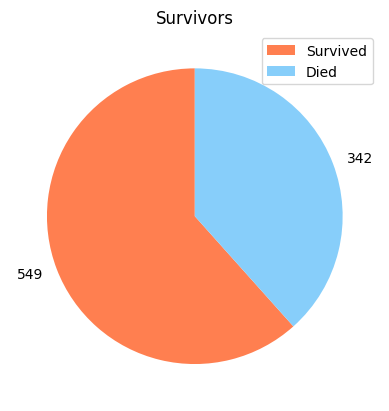

In [8]:
#pie chart
survivors = train_data['Survived'].value_counts()   #values of bool
fig, ax = plt.subplots()                                    #generate plots
ax.pie(survivors, labels = survivors, startangle=90, colors=['coral', 'lightskyblue'] )        #generate pie (values, values in chart shown, starting angle)
ax.set_title('Survivors')                                   #title
ax.legend(['Survived', 'Died'])                             #legend
plt.show()

## 2.3 Pclass
Passenger class. Complete set. Can be used as category for prediction.  

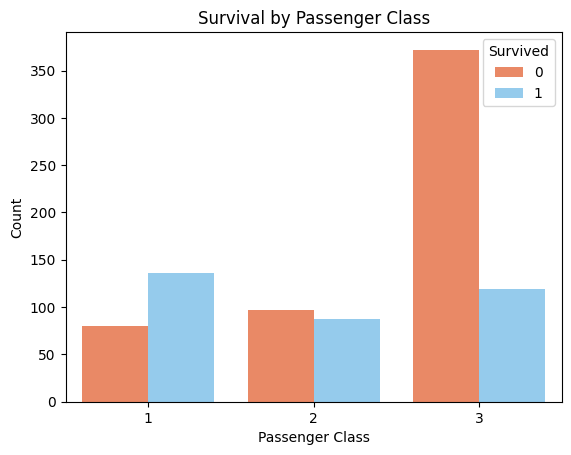

In [9]:
# Create a bar plot to show the relation between survival and Pclass
sns.countplot(data=train_data, x='Pclass', hue='Survived', palette=['coral', 'lightskyblue'])

# Add title and labels
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')

# Show the plot
plt.show()

## 2.4 Name
Complete data.

### 2.4.1 Split Name
Can be split into FirstName, LastName and Salutation.

In [10]:
#Do the split operation for test and train data
train_data = train_class.SplitName()
test_data = test_class.SplitName()

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


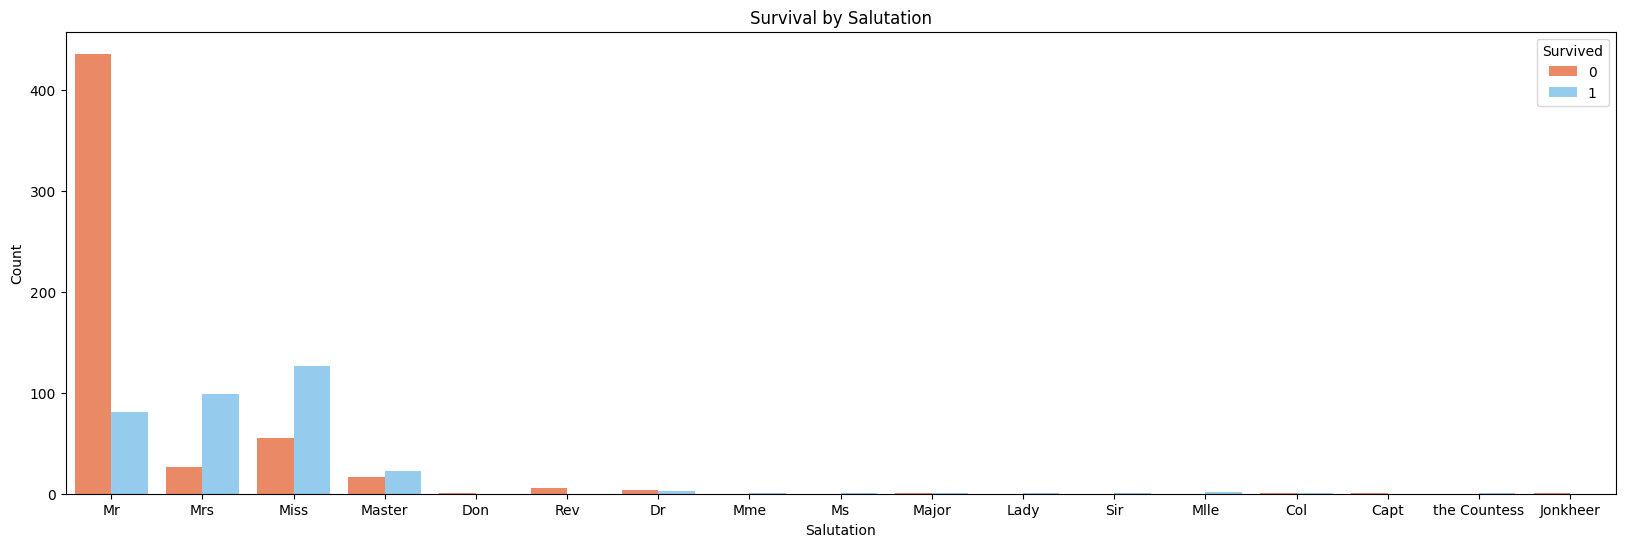

In [11]:
#Create figure with certain size
plt.figure(figsize=(20, 6))  # Adjust the width and height as needed

# Create a bar plot to show the relation between survival and Salutation
sns.countplot(data=train_data, x='Salutation', hue='Survived', palette=['coral', 'lightskyblue'])

# Add title and labels
plt.title('Survival by Salutation')
plt.xlabel('Salutation')
plt.ylabel('Count')

# Show the plot
plt.show()

### 2.4.2 Encode of LastName and Salutation
 LastName and Salutation can be encoded for grouping. 

In [12]:
#call encoding method on train and test data
enc_val = ['LastName', 'Salutation']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,73,11,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,136,12,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,251,8,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,198,12,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,11,11,William Henry


## 2.5 Sex
Complete data.

In [13]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,73,11,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,136,12,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,251,8,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,198,12,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,11,11,William Henry


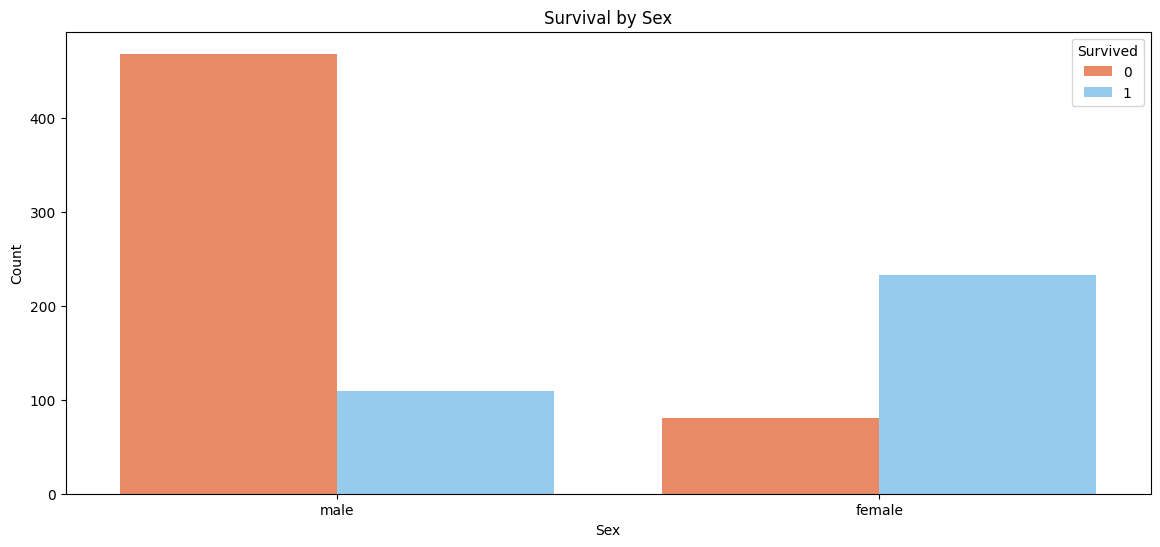

In [14]:
#Create figure with certain size
plt.figure(figsize=(14, 6))  # Adjust the width and height as needed

# Create a bar plot to show the relation between survival and Salutation
sns.countplot(data=train_data, x='Sex', hue='Survived', palette=['coral', 'lightskyblue'])

# Add title and labels
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')

# Show the plot
plt.show()

### 2.5.1 Encoding of Sex
change male and female into 0s and 1s.

In [15]:
#call encoding method on train and test data
enc_val = ['Sex']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

## 2.6 Age

In [16]:
#calculate percentage of missing age
missing_age = train_data.Age.isnull().sum()
total_row_count = train_data.PassengerId.count()

percentage_missing_age_data = round(missing_age/total_row_count*100, 0)

print(percentage_missing_age_data)

20.0


20 % of the age data is missing.

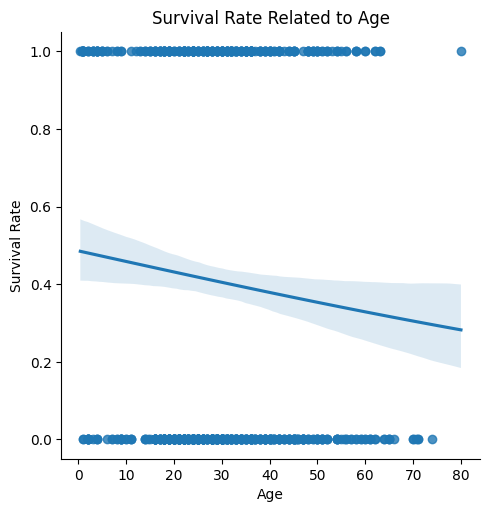

In [17]:
# Create a linear regression plot of the survival rate related to age
sns.lmplot(x='Age', y='Survived', data=train_data, logistic=True)

# Add title and labels
plt.title('Survival Rate Related to Age')
plt.xlabel('Age')
plt.ylabel('Survival Rate')

# Show the plot
plt.show()

### 2.6.1 Impute of Age
 This column has potential. Let´s see if imputing helps:
- mean impute --> lower score
- mean impute incl. impute_extension (extra column with info whether age was imputed or not) --> same score as without impute.
- median impute, incl. impute_extension --> same score as without imputing
- most_frequent, incl. impute extension --> Higher score (without impute extension same result as with)

In [18]:
#Create a new column 'age_impute_extension' that indicates if age was imputed (not necessary)
train_data['Age_impute_extension'] = train_data['Age'].isnull()   #gives true where data is missing
test_data['Age_impute_extension'] = test_data['Age'].isnull()   #gives true where data is missing

# Define imputer with mean strategy. It will overwrite the missing values with the mean of the age.
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputer to the Age column
train_data['Age'] = imputer.fit_transform(train_data[['Age']]) #train_data[['Age']] uses the Age column as df

#check
train_data.Age.isnull().sum()

np.int64(0)

### 2.6.2 Encode of Age_impute_extension

In [19]:
#call encoding method on train and test data
enc_val = ['Age_impute_extension']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

In [20]:
train_data['Age'].unique()

array([22.  , 38.  , 26.  , 35.  , 24.  , 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 46.  , 59.  , 71.  ,
       37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
       55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
       20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
       10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
       24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

## 2.7 SibSp
Number of siblings on board. Complete Data. Can be used for prediction. 

<Axes: xlabel='SibSp', ylabel='Count'>

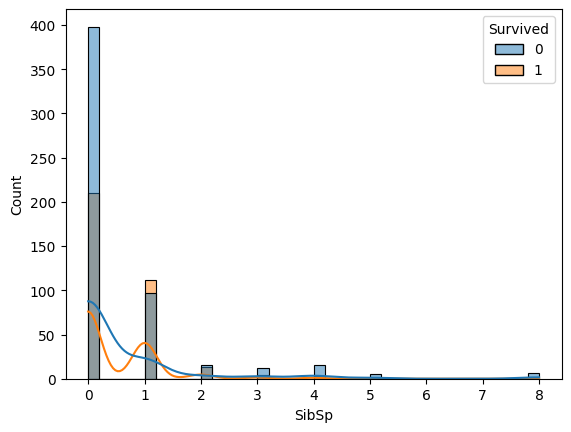

In [21]:
sns.histplot(data=train_data, x='SibSp', hue='Survived', bins=40, kde=True)

## 2.8 Parch
Number of parents or kids on board. Complete data. Can be used for prediction. 

In [22]:
train_data.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6])

<Axes: xlabel='Parch', ylabel='Count'>

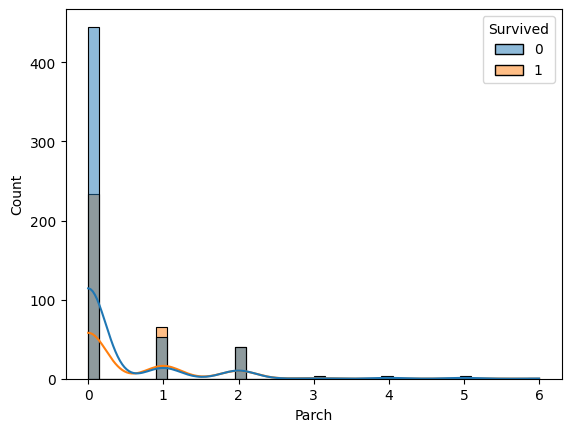

In [23]:
sns.histplot(data=train_data, x='Parch', hue='Survived', bins=40, kde=True)

### 2.8.1 Family size
Let´s sum # of siblings and # of parents/kids together, to get the family size and use this as a feature. Also add '+1' for the passanger himself

In [24]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1 
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

<Axes: xlabel='FamilySize', ylabel='Count'>

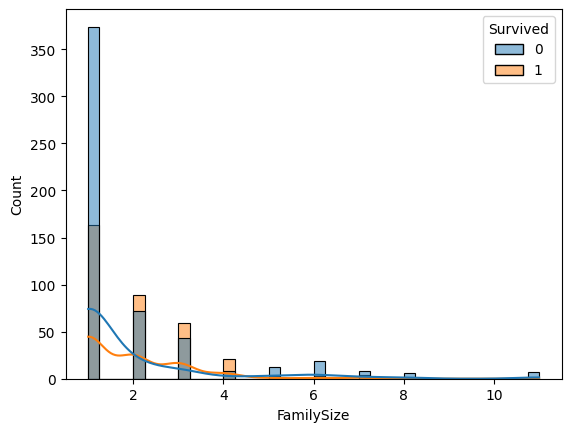

In [25]:
sns.histplot(data=train_data, x='FamilySize', hue='Survived', bins=40, kde=True)

## 2.9 Ticket
Ticket prefix can be used for prediction

### 2.9.1 Create ticket prefix

In [26]:
# Create a new column 'TicketPrefix' to extract the prefix of the ticket
train_data['TicketPrefix'] = train_data['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'No Prefix') #len... checks if there is more then one element after the split
test_data['TicketPrefix'] = test_data['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'No Prefix')

In [27]:
train_data['TicketPrefix'].value_counts()

TicketPrefix
No Prefix     665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

### 2.9.2 Encoding of TicketPrefix

In [28]:
#call encoding method on train and test data
enc_val = ['TicketPrefix']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname,Age_impute_extension,FamilySize,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,73,11,Owen Harris,0,2,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,136,12,John Bradley (Florence Briggs Thayer),0,2,18
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,251,8,Laina,0,1,37
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,198,12,Jacques Heath (Lily May Peel),0,2,16
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,11,11,William Henry,0,1,16


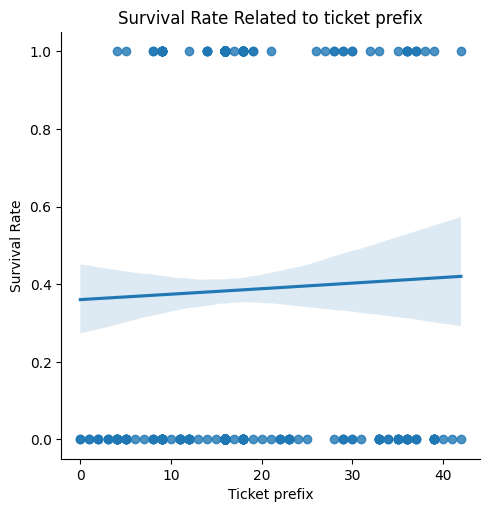

In [29]:
# Create a linear regression plot of the survival rate related to age
sns.lmplot(x='TicketPrefix', y='Survived', data=train_data, logistic=True)

# Add title and labels
plt.title('Survival Rate Related to ticket prefix')
plt.xlabel('Ticket prefix')
plt.ylabel('Survival Rate')

# Show the plot
plt.show()

## 2.10 Fare
Complete data. Will be used for prediction.

<Axes: xlabel='Fare', ylabel='Count'>

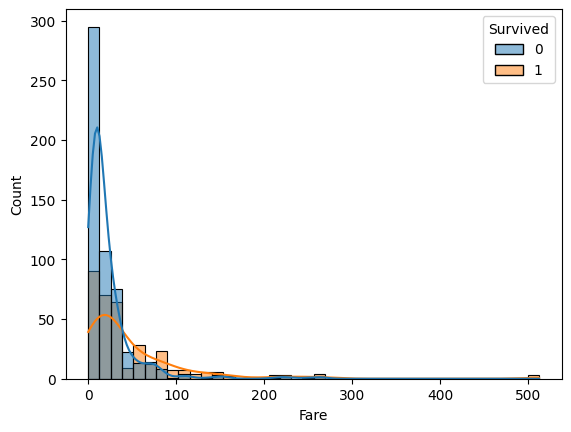

In [30]:
sns.histplot(data=train_data, x='Fare', hue='Survived', bins=40, kde=True)

## 2.11 Cabin

In [31]:
#calculate percentage of missing cabin data
missing_cabin = train_data.Cabin.isnull().sum()
total_row_count = train_data.PassengerId.count()

percentage_missing_cabin_data = round(missing_cabin/total_row_count*100, 0)

print(percentage_missing_cabin_data)

77.0


Incomplete data. 77 % of the data is missing. This is too much for a proper imputation. 

In [32]:
#Let´s take a look at the data we have.
train_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [33]:
# Filter rows where Cabin length is greater than 4 and sort by Cabin
long_cabin_numbers_sorted = train_data[train_data['Cabin'].str.len() > 4].sort_values(by='Cabin')
long_cabin_numbers_sorted['Cabin'].value_counts()

Cabin
B96 B98            4
C23 C25 C27        4
C22 C26            3
B51 B53 B55        2
B57 B59 B63 B66    2
B58 B60            2
F G73              2
B82 B84            1
C62 C64            1
D10 D12            1
F E69              1
F G63              1
Name: count, dtype: int64

In [34]:
# Filter passengers with cabin 'B96'
passengers_with_b96 = train_data[train_data['Cabin'] == 'B96 B98']
passengers_with_b96.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname,Age_impute_extension,FamilySize,TicketPrefix
390,391,1,1,"Carter, Mr. William Ernest",1,36.0,1,2,113760,120.0,B96 B98,S,100,11,William Ernest,0,4,16
435,436,1,1,"Carter, Miss. Lucile Polk",0,14.0,1,2,113760,120.0,B96 B98,S,100,8,Lucile Polk,0,4,16
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",0,36.0,1,2,113760,120.0,B96 B98,S,100,12,William Ernest (Lucile Polk),0,4,16
802,803,1,1,"Carter, Master. William Thornton II",1,11.0,1,2,113760,120.0,B96 B98,S,100,7,William Thornton II,0,4,16


### 2.11.1 Strip cabin data

So if a family was travelling together in several cabins, every passanger has all of them cabins written in the cabin cell. Let´s use only the last cabin of each. 

And there are also cabins with two letters, let´s only use the last one. 

In [35]:
#use only the part behind ' '
train_data['Cabin'] = train_data['Cabin'].str.split().str[-1]
test_data['Cabin'] = test_data['Cabin'].str.split().str[-1]

### 2.11.2 Split cabin data
The cabin gives info about the deck (letter) and where on the deck the cabin was located (number). 

In [36]:
#call split cabin on train and test data
train_data = train_class.SplitCabin()
test_data = test_class.SplitCabin()

In [37]:
#check data
train_data.Deck.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

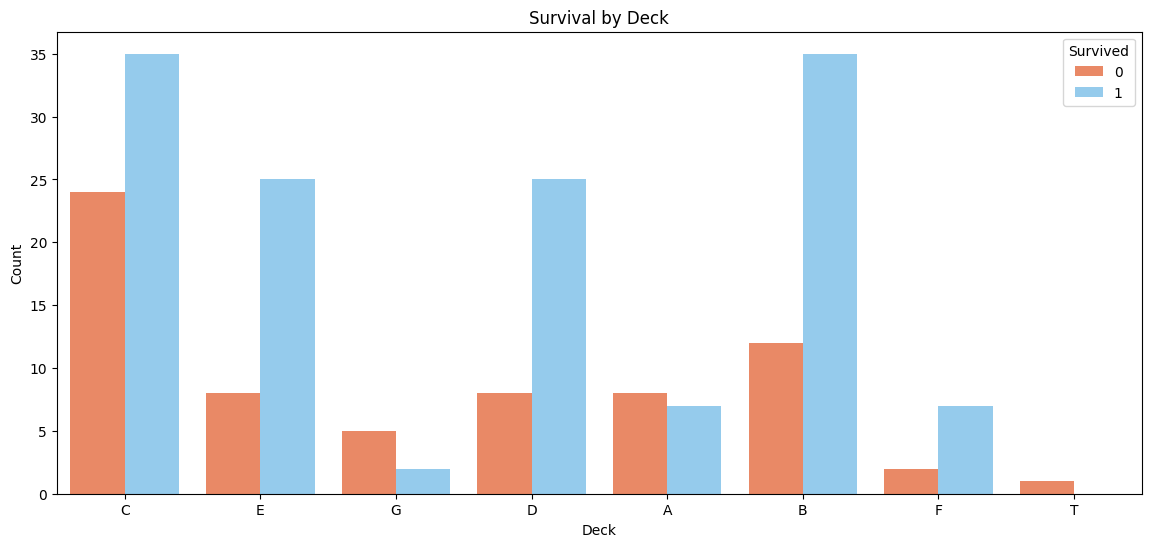

In [38]:
#Create figure with certain size
plt.figure(figsize=(14, 6))  # Adjust the width and height as needed

# Create a bar plot to show the relation between survival and Salutation
sns.countplot(data=train_data, x='Deck', hue='Survived', palette=['coral', 'lightskyblue'])

# Add title and labels
plt.title('Survival by Deck')
plt.xlabel('Deck')
plt.ylabel('Count')

# Show the plot
plt.show()

In [39]:
#check data
train_data.CabinNumber.unique()

array([nan, '85', '123', '46', '6', '103', '56', '27', '78', '33', '30',
       '52', '28', '83', '73', '31', '5', '12', '26', '110', '60', '101',
       '69', '47', '86', '2', '19', '7', '49', '4', '32', '80', '36',
       '15', '93', '35', '87', '77', '67', '94', '125', '99', '118', '',
       '106', '65', '54', '66', '34', '18', '124', '91', '40', '128',
       '37', '50', '82', '98', '10', '44', '104', '111', '92', '38', '21',
       '63', '14', '20', '79', '25', '95', '39', '22', '70', '16', '68',
       '41', '9', '23', '48', '58', '126', '71', '55', '64', '24', '90',
       '45', '8', '121', '11', '3', '84', '17', '102', '42', '148'],
      dtype=object)

<Axes: xlabel='CabinNumber', ylabel='Count'>

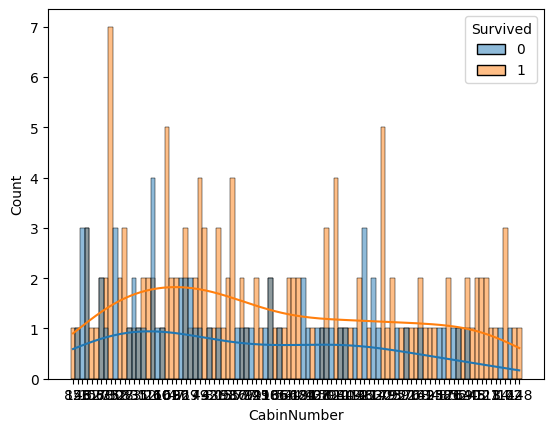

In [40]:
sns.histplot(data=train_data, x='CabinNumber', hue='Survived', bins=40, kde=True)

In [41]:
# Replace empty CabinNumber values with NaN
train_data['CabinNumber'].replace('', np.nan, inplace=True) #inplace=True --> replacement in the original df
test_data['CabinNumber'].replace('', np.nan, inplace=True)

/var/folders/f2/cvvypqtx55v6z0psthg91gnr0000gn/T/ipykernel_30709/1351360821.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['CabinNumber'].replace('', np.nan, inplace=True) #inplace=True --> replacement in the original df
/var/folders/f2/cvvypqtx55v6z0psthg91gnr0000gn/T/ipykernel_30709/1351360821.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because

### 2.11.3 Encode cabin deck

In [42]:
#call encoding method on train and test data
enc_val = ['Deck']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname,Age_impute_extension,FamilySize,TicketPrefix,Deck,CabinNumber
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,73,11,Owen Harris,0,2,4,8,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,136,12,John Bradley (Florence Briggs Thayer),0,2,18,2,85
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,251,8,Laina,0,1,37,8,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,198,12,Jacques Heath (Lily May Peel),0,2,16,2,123
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,11,11,William Henry,0,1,16,8,NaN


## 2.12 Embarked

In [43]:
train_data.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

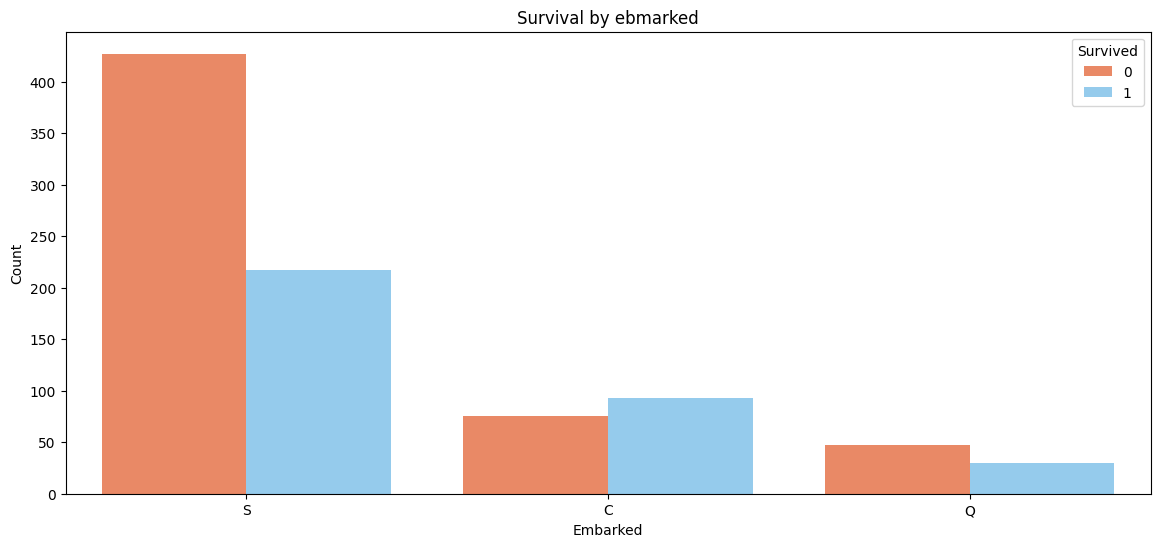

In [44]:
#Create figure with certain size
plt.figure(figsize=(14, 6))  # Adjust the width and height as needed

# Create a bar plot to show the relation between survival and Salutation
sns.countplot(data=train_data, x='Embarked', hue='Survived', palette=['coral', 'lightskyblue'])

# Add title and labels
plt.title('Survival by ebmarked')
plt.xlabel('Embarked')
plt.ylabel('Count')

# Show the plot
plt.show()

In [45]:
# check for the two people with missing embarked data
train_data[train_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Salutation,Surname,Age_impute_extension,FamilySize,TicketPrefix,Deck,CabinNumber
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,275,8,Amelie,0,1,16,1,28
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,584,12,George Nelson (Martha Evelyn),0,1,16,1,28


In [46]:
train_data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

### 2.12.1 Two missing data
Most people embarked in Southhampton. So let´s assume the two people also embarked there too.

In [47]:
# write 'S' at their Index numbers in cell 'Embarked'
train_data.loc[[61, 829], 'Embarked'] = 'S'

train_data.Embarked.describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

### 2.12.2 Encode of embarked

In [48]:
#call encoding method on train and test data
enc_val = ['Embarked']
train_data = train_class.LabelEncoding(enc_val)
test_data = test_class.LabelEncoding(enc_val)

___

# 3 Modeling and prediction

## 3.1 Choose features

### 3.1.1 Correlation of features

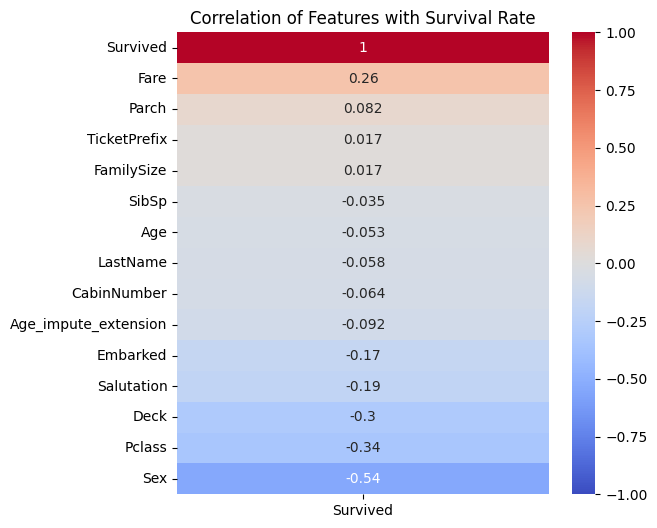

In [49]:
# Calculate the correlation matrix using the specified columns
correlation_matrix = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Fare', 'Embarked', 'Deck', 'Age_impute_extension', 'TicketPrefix', 'LastName', 'Salutation', 'CabinNumber', 'Survived']].corr()

# Create a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix[['Survived']].sort_values(by='Survived', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Survival Rate')
plt.show()

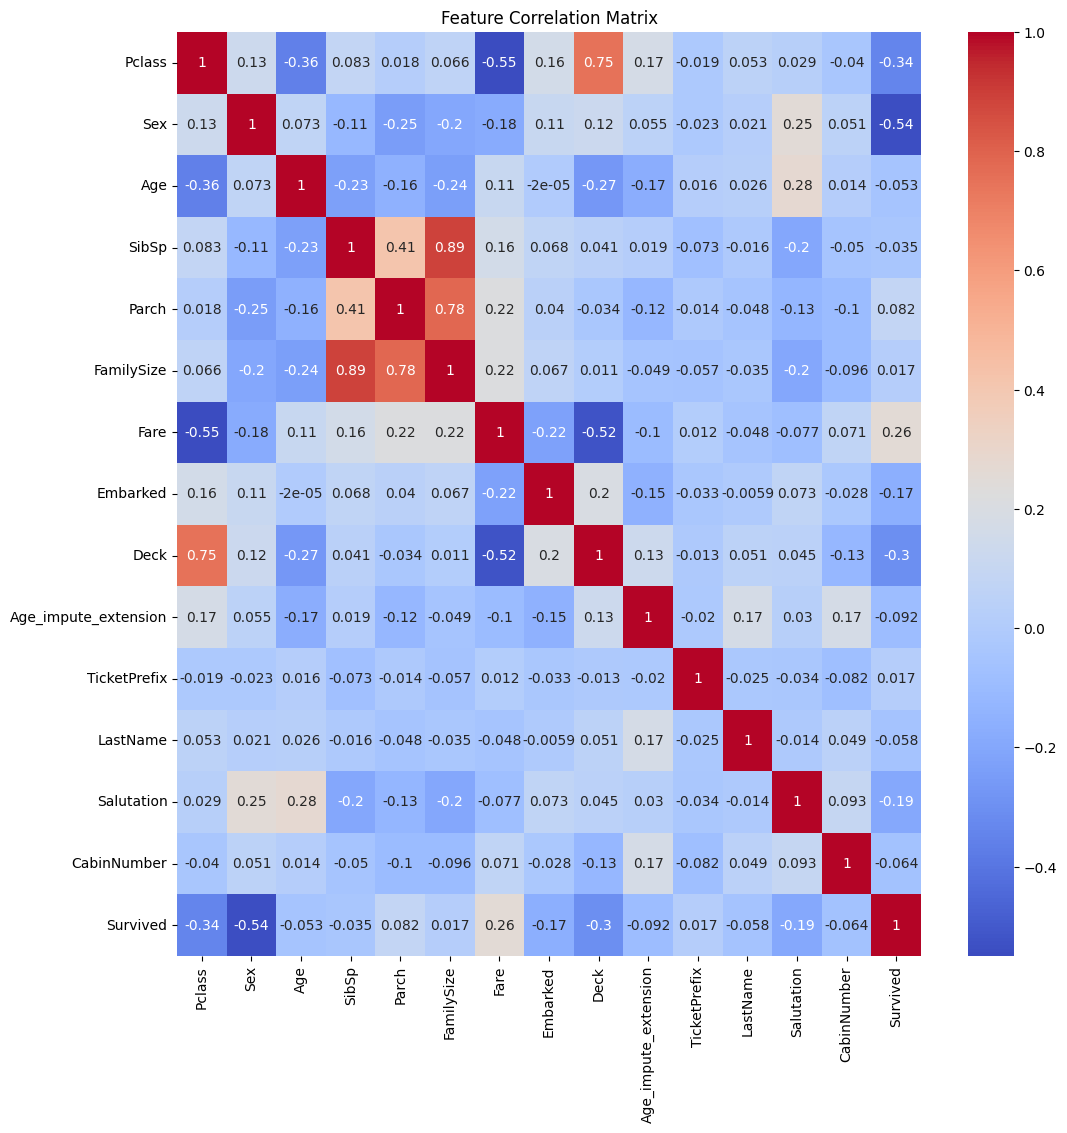

In [50]:
#feature correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [51]:
#choose possible related infos
data_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Age_impute_extension']

The score is higher without: 
- 'CabinNumber'
- 'Salutation'
- 'TicketPrefix'
- 'LastName'

The score is lower:
- with 'FamilySize' instead of 'Parch' and 'SibSp'
- Without 'Fare'


## 3.2 Modeling
Create model class object (instance)

In [52]:
#create class object
cl_object = ModelClass(test_data)

## 3.3 Run prediction

In [53]:
result = cl_object.ChooseModel(([1,2,3,4]))

result.head()

,Name,MAE,Accuracy,Result
1,DecisionTreeClassifier,0.260090,0.772727,PassengerId Pclass ...
2,RandomForestClassifier,0.228700,0.825359,PassengerId Pclass ...
3,DecisionTreeRegressor,0.260090,0.772727,PassengerId Pclass ...
4,RandomForestRegressor,0.242152,0.832536,PassengerId Pclass ...


In [54]:
#confusion matrix
# Get the true values and predicted values
true_values = true_data['Survived']
predicted_values = result.loc[2, 'Result']['Survived']

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_values)

print(conf_matrix)

[[231  35]
 [ 35 117]]


## 3.4 Choose version of model and create file
Which one should be printed? Choose Index:

In [55]:
#request input (force to int)
inp_val = int(input("Which version should be printed to .CSV? Please choose from index in header '3.3'"))

#use new df for printing
print_data = result.loc[inp_val, 'Result']

#use only passanger ID and survived for output
print_data = print_data[['PassengerId', 'Survived']]

#save to csv file. index=False to have no index column
print_data.to_csv('result/results.csv', index=False)
print('Your file was created')


Your file was created


---

# 9 Archive

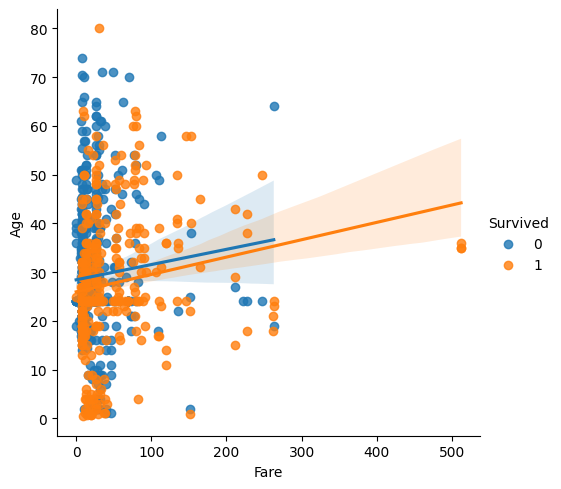

In [56]:
sns.lmplot(x="Fare", y="Age", hue="Survived", data=train_data)